In [1]:
from __future__ import print_function
import numpy as np
from TileCoding import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# all possible actions
ACTION_REVERSE = -1
ACTION_ZERO = 0
ACTION_FORWARD = 1
# order is important
ACTIONS = [ACTION_REVERSE, ACTION_ZERO, ACTION_FORWARD]

# bound for position and velocity
POSITION_MIN = -1.2
POSITION_MAX = 0.5
VELOCITY_MIN = -0.07
VELOCITY_MAX = 0.07

# use optimistic initial value, so it's ok to set epsilon to 0
EPSILON = 0


In [3]:
# take an @action at @position and @velocity
# @return: new position, new velocity, reward (always -1)
def takeAction(position, velocity, action):
    newVelocity = velocity + 0.001 * action - 0.0025 * np.cos(3 * position)
    newVelocity = min(max(VELOCITY_MIN, newVelocity), VELOCITY_MAX)
    newPosition = position + newVelocity
    newPosition = min(max(POSITION_MIN, newPosition), POSITION_MAX)
    reward = -1.0
    if newPosition == POSITION_MIN:
        newVelocity = 0.0
    return newPosition, newVelocity, reward



In [4]:
# wrapper class for state action value function
class ValueFunction:
    # In this example I use the tiling software instead of implementing standard tiling by myself
    # One important thing is that tiling is only a map from (state, action) to a series of indices
    # It doesn't matter whether the indices have meaning, only if this map satisfy some property
    # View the following webpage for more information
    # http://incompleteideas.net/sutton/tiles/tiles3.html
    # @maxSize: the maximum # of indices
    def __init__(self, stepSize, numOfTilings=8, maxSize=2048):
        self.maxSize = maxSize
        self.numOfTilings = numOfTilings

        # divide step size equally to each tiling
        self.stepSize = stepSize / numOfTilings

        self.hashTable = IHT(maxSize)

        # weight for each tile
        self.weights = np.zeros(maxSize)

        # position and velocity needs scaling to satisfy the tile software
        self.positionScale = self.numOfTilings / (POSITION_MAX - POSITION_MIN)
        self.velocityScale = self.numOfTilings / (VELOCITY_MAX - VELOCITY_MIN)

    # get indices of active tiles for given state and action
    def getActiveTiles(self, position, velocity, action):
        # I think positionScale * (position - position_min) would be a good normalization.
        # However positionScale * position_min is a constant, so it's ok to ignore it.
        activeTiles = tiles(self.hashTable, self.numOfTilings,
                            [self.positionScale * position, self.velocityScale * velocity],
                            [action])
        return activeTiles

    # estimate the value of given state and action
    def value(self, position, velocity, action):
        if position == POSITION_MAX:
            return 0.0
        activeTiles = self.getActiveTiles(position, velocity, action)
        return np.sum(self.weights[activeTiles])

    # learn with given state, action and target
    def learn(self, position, velocity, action, target):
        activeTiles = self.getActiveTiles(position, velocity, action)
        estimation = np.sum(self.weights[activeTiles])
        delta = self.stepSize * (target - estimation)
        for activeTile in activeTiles:
            self.weights[activeTile] += delta

    # get # of steps to reach the goal under current state value function
    def costToGo(self, position, velocity):
        costs = []
        for action in ACTIONS:
            costs.append(self.value(position, velocity, action))
        return -np.max(costs)

In [5]:
# get action at @position and @velocity based on epsilon greedy policy and @valueFunction
def getAction(position, velocity, valueFunction):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    values = []
    for action in ACTIONS:
        values.append(valueFunction.value(position, velocity, action))
    return np.argmax(values) - 1

# semi-gradient n-step Sarsa
# @valueFunction: state value function to learn
# @n: # of steps
def semiGradientNStepSarsa(valueFunction, n=1):
    # start at a random position around the bottom of the valley
    currentPosition = np.random.uniform(-0.6, -0.4)
    # initial velocity is 0
    currentVelocity = 0.0
    # get initial action
    currentAction = getAction(currentPosition, currentVelocity, valueFunction)

    # track previous position, velocity, action and reward
    positions = [currentPosition]
    velocities = [currentVelocity]
    actions = [currentAction]
    rewards = [0.0]

    # track the time
    time = 0

    # the length of this episode
    T = float('inf')
    while True:
        # go to next time step
        time += 1

        if time < T:
            # take current action and go to the new state
            newPostion, newVelocity, reward = takeAction(currentPosition, currentVelocity, currentAction)
            # choose new action
            newAction = getAction(newPostion, newVelocity, valueFunction)

            # track new state and action
            positions.append(newPostion)
            velocities.append(newVelocity)
            actions.append(newAction)
            rewards.append(reward)

            if newPostion == POSITION_MAX:
                T = time

        # get the time of the state to update
        updateTime = time - n
        if updateTime >= 0:
            returns = 0.0
            # calculate corresponding rewards
            for t in range(updateTime + 1, min(T, updateTime + n) + 1):
                returns += rewards[t]
            # add estimated state action value to the return
            if updateTime + n <= T:
                returns += valueFunction.value(positions[updateTime + n],
                                               velocities[updateTime + n],
                                               actions[updateTime + n])
            # update the state value function
            if positions[updateTime] != POSITION_MAX:
                valueFunction.learn(positions[updateTime], velocities[updateTime], actions[updateTime], returns)
        if updateTime == T - 1:
            break
        currentPosition = newPostion
        currentVelocity = newVelocity
        currentAction = newAction

    return time

In [6]:
figureIndex = 0
# print learned cost to go
def prettyPrint(valueFunction, title):
    global figureIndex
    gridSize = 40
    positionStep = (POSITION_MAX - POSITION_MIN) / gridSize
    positions = np.arange(POSITION_MIN, POSITION_MAX + positionStep, positionStep)
    velocityStep = (VELOCITY_MAX - VELOCITY_MIN) / gridSize
    velocities = np.arange(VELOCITY_MIN, VELOCITY_MAX + velocityStep, velocityStep)
    axisX = []
    axisY = []
    axisZ = []
    for position in positions:
        for velocity in velocities:
            axisX.append(position)
            axisY.append(velocity)
            axisZ.append(valueFunction.costToGo(position, velocity))

    fig = plt.figure(figureIndex)
    figureIndex += 1
    fig.suptitle(title)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(axisX, axisY, axisZ)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Cost to go')

In [17]:
# Figure 10.1, cost to go in a single run
def figure10_1():
    episodes = 9000
    targetEpisodes = [0, 99, episodes - 1]
    numOfTilings = 8
    alpha = 0.3
    valueFunction = ValueFunction(alpha, numOfTilings)
    for episode in range(0, episodes):
        #print('episode:', episode)
        semiGradientNStepSarsa(valueFunction)
#         if episode in targetEpisodes:
#             prettyPrint(valueFunction, 'Episode: ' + str(episode + 1))

In [8]:
# Figure 10.2, semi-gradient Sarsa with different alphas
def figure10_2():
    runs = 10
    episodes = 500
    numOfTilings = 8
    alphas = [0.1, 0.2, 0.5]

    steps = np.zeros((len(alphas), episodes))
    for run in range(0, runs):
        valueFunctions = [ValueFunction(alpha, numOfTilings) for alpha in alphas]
        for index in range(0, len(valueFunctions)):
            for episode in range(0, episodes):
                #print('run:', run, 'alpha:', alphas[index], 'episode:', episode)
                step = semiGradientNStepSarsa(valueFunctions[index])
                steps[index, episode] += step

    steps /= runs

    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    for i in range(0, len(alphas)):
        plt.plot(steps[i], label='alpha = '+str(alphas[i])+'/'+str(numOfTilings))
    plt.xlabel('Episode')
    plt.ylabel('Steps per episode')
    plt.yscale('log')
    plt.legend()

In [9]:
# Figure 10.3, one-step semi-gradient Sarsa vs multi-step semi-gradient Sarsa
def figure10_3():
    runs = 10
    episodes = 500
    numOfTilings = 8
    alphas = [0.5, 0.3]
    nSteps = [1, 8]

    steps = np.zeros((len(alphas), episodes))
    for run in range(0, runs):
        valueFunctions = [ValueFunction(alpha, numOfTilings) for alpha in alphas]
        for index in range(0, len(valueFunctions)):
            for episode in range(0, episodes):
#                 print('run:', run, 'steps:', nSteps[index], 'episode:', episode)
                step = semiGradientNStepSarsa(valueFunctions[index], nSteps[index])
                steps[index, episode] += step

    steps /= runs
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    for i in range(0, len(alphas)):
        plt.plot(steps[i], label='n = '+str(nSteps[i]))
    plt.xlabel('Episode')
    plt.ylabel('Steps per episode')
    plt.yscale('log')
    plt.legend()


In [10]:
# Figure 10.4, effect of alpha and n on multi-step semi-gradient Sarsa
def figure10_4():
    alphas = np.arange(0.25, 1.75, 0.25)
    nSteps = np.power(2, np.arange(0, 5))
    episodes = 50
    runs = 5

    truncateStep = 300
    steps = np.zeros((len(nSteps), len(alphas)))
    for run in range(0, runs):
        for nStepIndex, nStep in zip(range(0, len(nSteps)), nSteps):
            for alphaIndex, alpha in zip(range(0, len(alphas)), alphas):
                if (nStep == 8 and alpha > 1) or \
                        (nStep == 16 and alpha > 0.75):
                    # In these cases it won't converge, so ignore them
                    steps[nStepIndex, alphaIndex] += truncateStep * episodes
                    continue
                valueFunction = ValueFunction(alpha)
                for episode in range(0, episodes):
#                     print('run:', run, 'steps:', nStep, 'alpha:', alpha, 'episode:', episode)
                    step = semiGradientNStepSarsa(valueFunction, nStep)
                    steps[nStepIndex, alphaIndex] += step
    # average over independent runs and episodes
    steps /= runs * episodes
    # truncate high values for better display
    steps[steps > truncateStep] = truncateStep

    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    for i in range(0, len(nSteps)):
        plt.plot(alphas, steps[i, :], label='n = '+str(nSteps[i]))
    plt.xlabel('alpha * number of tilings(8)')
    plt.ylabel('Steps per episode')
    plt.legend()

In [15]:
figure10_1()

plt.show()

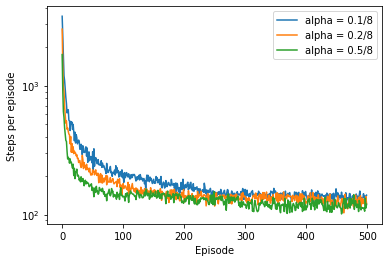

In [12]:
figure10_2()
plt.show()


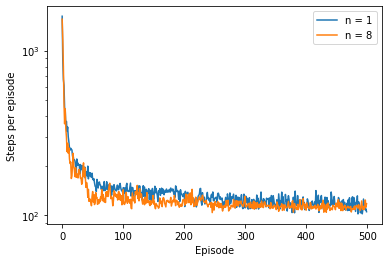

In [13]:
figure10_3()
plt.show()


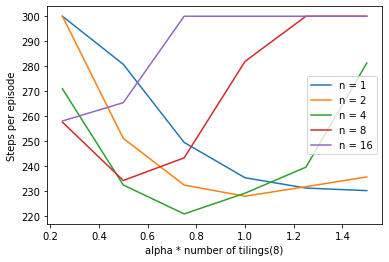

In [14]:
figure10_4()
plt.show()